# Описание

Что сделал:
* построил модель по предсказанию дефолта. Взял часть выборки в которой target не null. Оставшаяся часть не попала в модель.
  * маленький event rate -> критерий качества ROC AUC
  * результаты модели и график с основными переменными ниже


Какие данные добавил/убрал:
* в данные Заявки apps.csv добавил агрегаты из cart_items: количество товаров, средняя стоимость, мин/макс стоимость товара.
* возраст заемщика на момент обращения, разницу между суммой заявки и одобренной суммой



Проблемы с данными:
* нет справочника с укрупненным перечнем товаров: телефон/компьютер и т.д.
* склеил наименование товаров с табличкой кредитов, оказалось много пустых позиций: неизвестно на что именно брался кредит (аванс)
* json в pandas

Что можно добавить (есть данные):
* Время обращения (обращение в будний день хуже чем в выходной), историю обращений.
* строить модель не по заявке а по заемщику и проч
* проверку на hold-out, а не просто 5 fold validation

Что можно добавить (нет данных):
* пол, кредитная история

In [60]:
import pandas as pd
from pandasql import sqldf
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier
import json 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [61]:
ds_1 = pd.read_csv("/home/amadeus/Desktop/kaggle/Yury/Mokka_test/input_data/cart_items_amended.csv")
ds_1.drop(['Unnamed: 0'], axis=1, inplace = True)
ds_1.head()

,loan_application_id,name,price,quantity
0,7397173,Смартфон Apple iPhone 8 Plus 64GB Space Gray (...,44990.0,1
1,7397173,Чехол для iPhone Apple iPhone 8 Plus / 7 Plus ...,2990.0,1
2,7397174,Телевизор LG 32LK510,14990.0,1
3,7397177,Ноутбук Apple MacBook Air 13 i5 1.8/8Gb/128SSD...,64490.0,1
4,7397197,"Стиральная машина CANDY CS4 1051D1/2-07, фронт...",12470.0,1


In [62]:
ds_2 = pd.read_csv("/home/amadeus/Desktop/kaggle/Yury/Mokka_test/input_data/apps.csv",sep=';', engine="python", encoding='cp1251')

In [63]:
ds_2.head()

,target,loan_application_id,client_id,loan_application_key,previous_application_with_fico_key,federal_region_nm,city_nm,chain_nm,first_chain_nm,first_store_nm,...,application_dttm,application_amt,application_repeat_type,approved_flg,conversion_flg,loan_key,loan_order_num,start_dt,principal_amt,birth_dt
0,NaN,10566042,4272096,10518421,10510793,Волгоградская область,Волгоград,Eldorado DirectCredit pick-up,Mvideo DirectCredit pick-up,PUMVD390YUG,...,2020-03-31 10:47:47,1,preapplication,0,0,NaN,0,NaN,NaN,1994-05-19
1,NaN,10566033,4272187,10518412,10518412,Томская область,Томск,Mvideo DirectCredit pick-up,Mvideo DirectCredit pick-up,PUMVD642SIB,...,2020-03-31 10:47:09,1,preapplication,1,0,NaN,0,NaN,NaN,1978-11-03
2,NaN,10566031,4272184,10518410,10518410,г. Москва,Москва,Рево Client App,Рево Client App,Рево Client App,...,2020-03-31 10:47:07,1,preapplication,1,0,NaN,0,NaN,NaN,1996-11-05
3,NaN,10566028,4272118,10518407,10510936,г. Москва,Москва,Рево Client App,Детский Мир,DM1632VOL,...,2020-03-31 10:47:00,1,preapplication,0,0,NaN,1,NaN,NaN,1989-09-26
4,NaN,10566026,4272186,10518405,10518405,Свердловская область,Екатеринбург,Eldorado DirectCredit pick-up,Eldorado DirectCredit pick-up,PUELA671URL,...,2020-03-31 10:46:51,1,preapplication,0,0,NaN,0,NaN,NaN,1998-11-30


# Data merging

In [64]:
dataset = sqldf(
'''
SELECT
    DS2.*
    ,DS1.quantity
    ,DS1.total_price
    ,DS1.min_price
    ,DS1.max_price
    ,DS1.avg_price
FROM
    ds_2 DS2
LEFT JOIN
(
    SELECT
        loan_application_id
        ,SUM(quantity) AS quantity
        ,SUM(price) AS total_price
        ,MIN(price) AS min_price
        ,MAX(price) AS max_price
        ,AVG(price) AS avg_price
    FROM
        ds_1
    GROUP BY
        loan_application_id
) DS1
ON
    DS2.loan_application_id = DS1.loan_application_id
'''
)

# Generate features

In [65]:
#bin_labels_5 = ['A_amt', 'B_amt', 'C_amt', 'D_amt', 'E_amt']
dataset['application_amt'] = dataset['application_amt'].apply(lambda x: x.replace(',','.'))
dataset['application_amt'] = pd.to_numeric(dataset['application_amt'])
#dataset['principal_amt'] = dataset['principal_amt'].notnull().apply(lambda x: x.replace(',','.'))
dataset['principal_amt'] = dataset['principal_amt'].apply(lambda x: x.replace(',','.') if(pd.notnull(x)) else x)
dataset['principal_amt'] = pd.to_numeric(dataset['principal_amt'])    
#dataset['amt_quartiles'] = pd.qcut(dataset['application_amt'], 5, labels=bin_labels_5)

In [66]:
#Remove garbage
dataset = dataset[(dataset["birth_dt"] >= "1941-07-04") & (dataset["birth_dt"] < "2300-01-01")]
#Generate age
dataset['application_dttm'] = pd.to_datetime(dataset['application_dttm'])
dataset['birth_dt'] = pd.to_datetime(dataset['birth_dt'])
dataset["borrower_age_yy"] = (dataset['application_dttm'] - dataset['birth_dt'])
dataset["borrower_age_yy"] = ((dataset["borrower_age_yy"] / np.timedelta64(1, 'D')).astype(int)/365.25).astype(float)

In [67]:
print(dataset["borrower_age_yy"].min())
print(dataset["borrower_age_yy"].max())

-0.7912388774811773
78.64202600958248


In [68]:
#Сколько денег не хватило в абс и в %%
#dataset["money_shortage_amt"] = dataset["total_price"] - dataset["application_amt"]
dataset["money_shortage_amt"] = dataset["application_amt"] - dataset["principal_amt"]
dataset["money_shortage_perc"] = dataset["money_shortage_amt"]/dataset["total_price"]

In [69]:
dataset.count()

target                                  82662
loan_application_id                   1164811
client_id                             1164811
loan_application_key                  1164811
previous_application_with_fico_key    1164811
federal_region_nm                     1163936
city_nm                               1161477
chain_nm                              1164811
first_chain_nm                        1164811
first_store_nm                        1164811
channel_type                          1164811
application_dttm                      1164811
application_amt                       1164811
application_repeat_type               1164811
approved_flg                          1164811
conversion_flg                        1164811
loan_key                                82662
loan_order_num                        1164811
start_dt                                82662
principal_amt                           82662
birth_dt                              1164811
quantity                          

In [70]:
#dataset[(dataset["target"].notnull() & dataset["quantity"].isnull() )]

# Numerical features

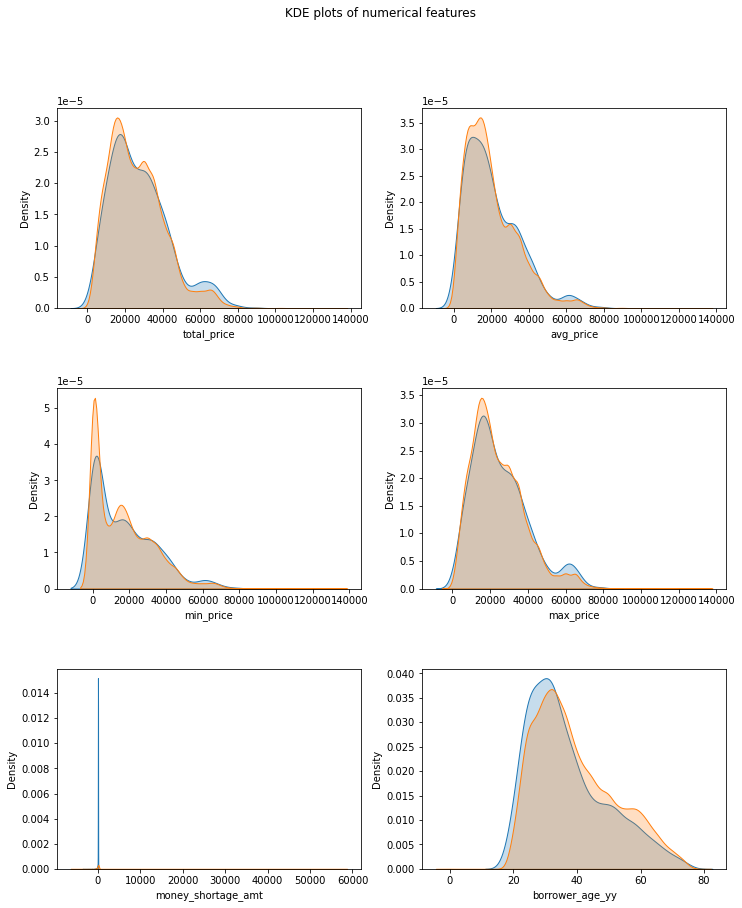

In [71]:
import warnings
warnings.filterwarnings("ignore")
numerical_cols = ["total_price", "avg_price", "min_price", "max_price", "money_shortage_amt", "borrower_age_yy"]
fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (12,14))
fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
fig.suptitle("KDE plots of numerical features")

for ax, col in zip(axes.flatten(), numerical_cols) :
    sns.kdeplot(dataset[(dataset["application_repeat_type"] != "preapplication") & ( dataset["target"] == 1)][col], shade="True", label="Not accepted", ax = ax)
    sns.kdeplot(dataset[(dataset["application_repeat_type"] != "preapplication") & ( dataset["target"] == 0)][col], shade="True", label="Rejected", ax = ax)
    ax.set_xlabel(col)

# Categorical features with low cardinality

In [72]:
df_train = dataset[dataset["target"].notnull()]

In [73]:
df_train.count()

target                                82662
loan_application_id                   82662
client_id                             82662
loan_application_key                  82662
previous_application_with_fico_key    82662
federal_region_nm                     82648
city_nm                               82571
chain_nm                              82662
first_chain_nm                        82662
first_store_nm                        82662
channel_type                          82662
application_dttm                      82662
application_amt                       82662
application_repeat_type               82662
approved_flg                          82662
conversion_flg                        82662
loan_key                              82662
loan_order_num                        82662
start_dt                              82662
principal_amt                         82662
birth_dt                              82662
quantity                              18847
total_price                     

# Cleaning

In [74]:
to_drop = ["loan_application_id", "client_id", "approved_flg",
           "loan_application_key", "previous_application_with_fico_key", "city_nm" , "first_chain_nm", "first_store_nm", "application_dttm", "loan_key","start_dt", "birth_dt", "application_amt"]
df_train.drop(to_drop, axis=1, inplace=True)

In [75]:
#df_train.count()

In [76]:
cat_cols_few = ["federal_region_nm", "chain_nm",
            "channel_type","application_repeat_type"]#, "amt_quartiles"]
for col in cat_cols_few:
        df_train[col].fillna(df_train[col].mode()[0], inplace=True)
df_train = pd.get_dummies(df_train, columns = cat_cols_few)

In [77]:
df_train.count()

target                                  82662
conversion_flg                          82662
loan_order_num                          82662
principal_amt                           82662
quantity                                18847
                                        ...  
channel_type_Full_online                82662
channel_type_Offline                    82662
channel_type_Online                     82662
application_repeat_type_false repeat    82662
application_repeat_type_new             82662
Length: 151, dtype: int64

In [78]:
df_train["target"] = (df_train["target"]).astype(int)
df_train

,target,conversion_flg,loan_order_num,principal_amt,quantity,total_price,min_price,max_price,avg_price,borrower_age_yy,...,chain_nm_Перевод на карту,chain_nm_Связной,chain_nm_Связной Онлайн,chain_nm_Сеть отсутствует в ChainLookup,chain_nm_Точка Зрения Пермь,channel_type_Full_online,channel_type_Offline,channel_type_Online,application_repeat_type_false repeat,application_repeat_type_new
7,0,1,1,14938.00,NaN,NaN,NaN,NaN,NaN,33.566051,...,0,0,0,0,0,0,0,1,1,0
23,0,1,1,5458.18,NaN,NaN,NaN,NaN,NaN,67.397673,...,0,0,0,0,0,0,1,0,0,1
27,0,1,1,10947.00,NaN,NaN,NaN,NaN,NaN,22.529774,...,0,0,0,0,0,0,1,0,0,1
70,0,1,1,23990.00,1.0,23990.0,23990.0,23990.0,23990.0,33.051335,...,0,0,0,0,0,0,0,1,1,0
92,0,1,1,44181.00,3.0,44181.0,0.0,26591.0,14727.0,27.728953,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165271,0,1,1,7433.00,NaN,NaN,NaN,NaN,NaN,24.933607,...,0,0,0,0,0,0,1,0,0,1
1165298,0,1,1,6425.00,NaN,NaN,NaN,NaN,NaN,58.176591,...,0,0,0,0,0,0,1,0,0,1
1165320,0,1,1,26453.70,NaN,NaN,NaN,NaN,NaN,30.135524,...,0,0,0,0,0,0,0,1,1,0
1165330,0,1,1,29990.00,NaN,NaN,NaN,NaN,NaN,22.360027,...,0,0,0,0,0,0,0,1,1,0


# Modelling

In [79]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(20, 25))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

In [80]:
num_folds = 5
train_df = df_train
print("LightGBM. Train shape: {}")
folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)

oof_preds = np.zeros(train_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['target']]
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df["target"])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df["target"].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df["target"].iloc[valid_idx]
    
    clf = LGBMClassifier(
        nthread=4,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=34,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.0222415,
        min_child_weight=39.3259775,
        silent=-1,
        verbose=-1, )
        
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del clf, train_x, train_y, valid_x, valid_y

print('Full AUC score %.6f' % roc_auc_score(train_df['target'], oof_preds))

LightGBM. Train shape: {}
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.721468	training's binary_logloss: 0.183386	valid_1's auc: 0.678635	valid_1's binary_logloss: 0.188434
[400]	training's auc: 0.736298	training's binary_logloss: 0.180604	valid_1's auc: 0.684296	valid_1's binary_logloss: 0.187733
[600]	training's auc: 0.746725	training's binary_logloss: 0.178682	valid_1's auc: 0.685715	valid_1's binary_logloss: 0.187552
[800]	training's auc: 0.752239	training's binary_logloss: 0.177634	valid_1's auc: 0.685631	valid_1's binary_logloss: 0.187615
Early stopping, best iteration is:
[653]	training's auc: 0.748422	training's binary_logloss: 0.178361	valid_1's auc: 0.686028	valid_1's binary_logloss: 0.187525
Fold  1 AUC : 0.686028
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: n

In [81]:
print('Full AUC score %.6f' % roc_auc_score(train_df['target'], oof_preds))

Full AUC score 0.690965


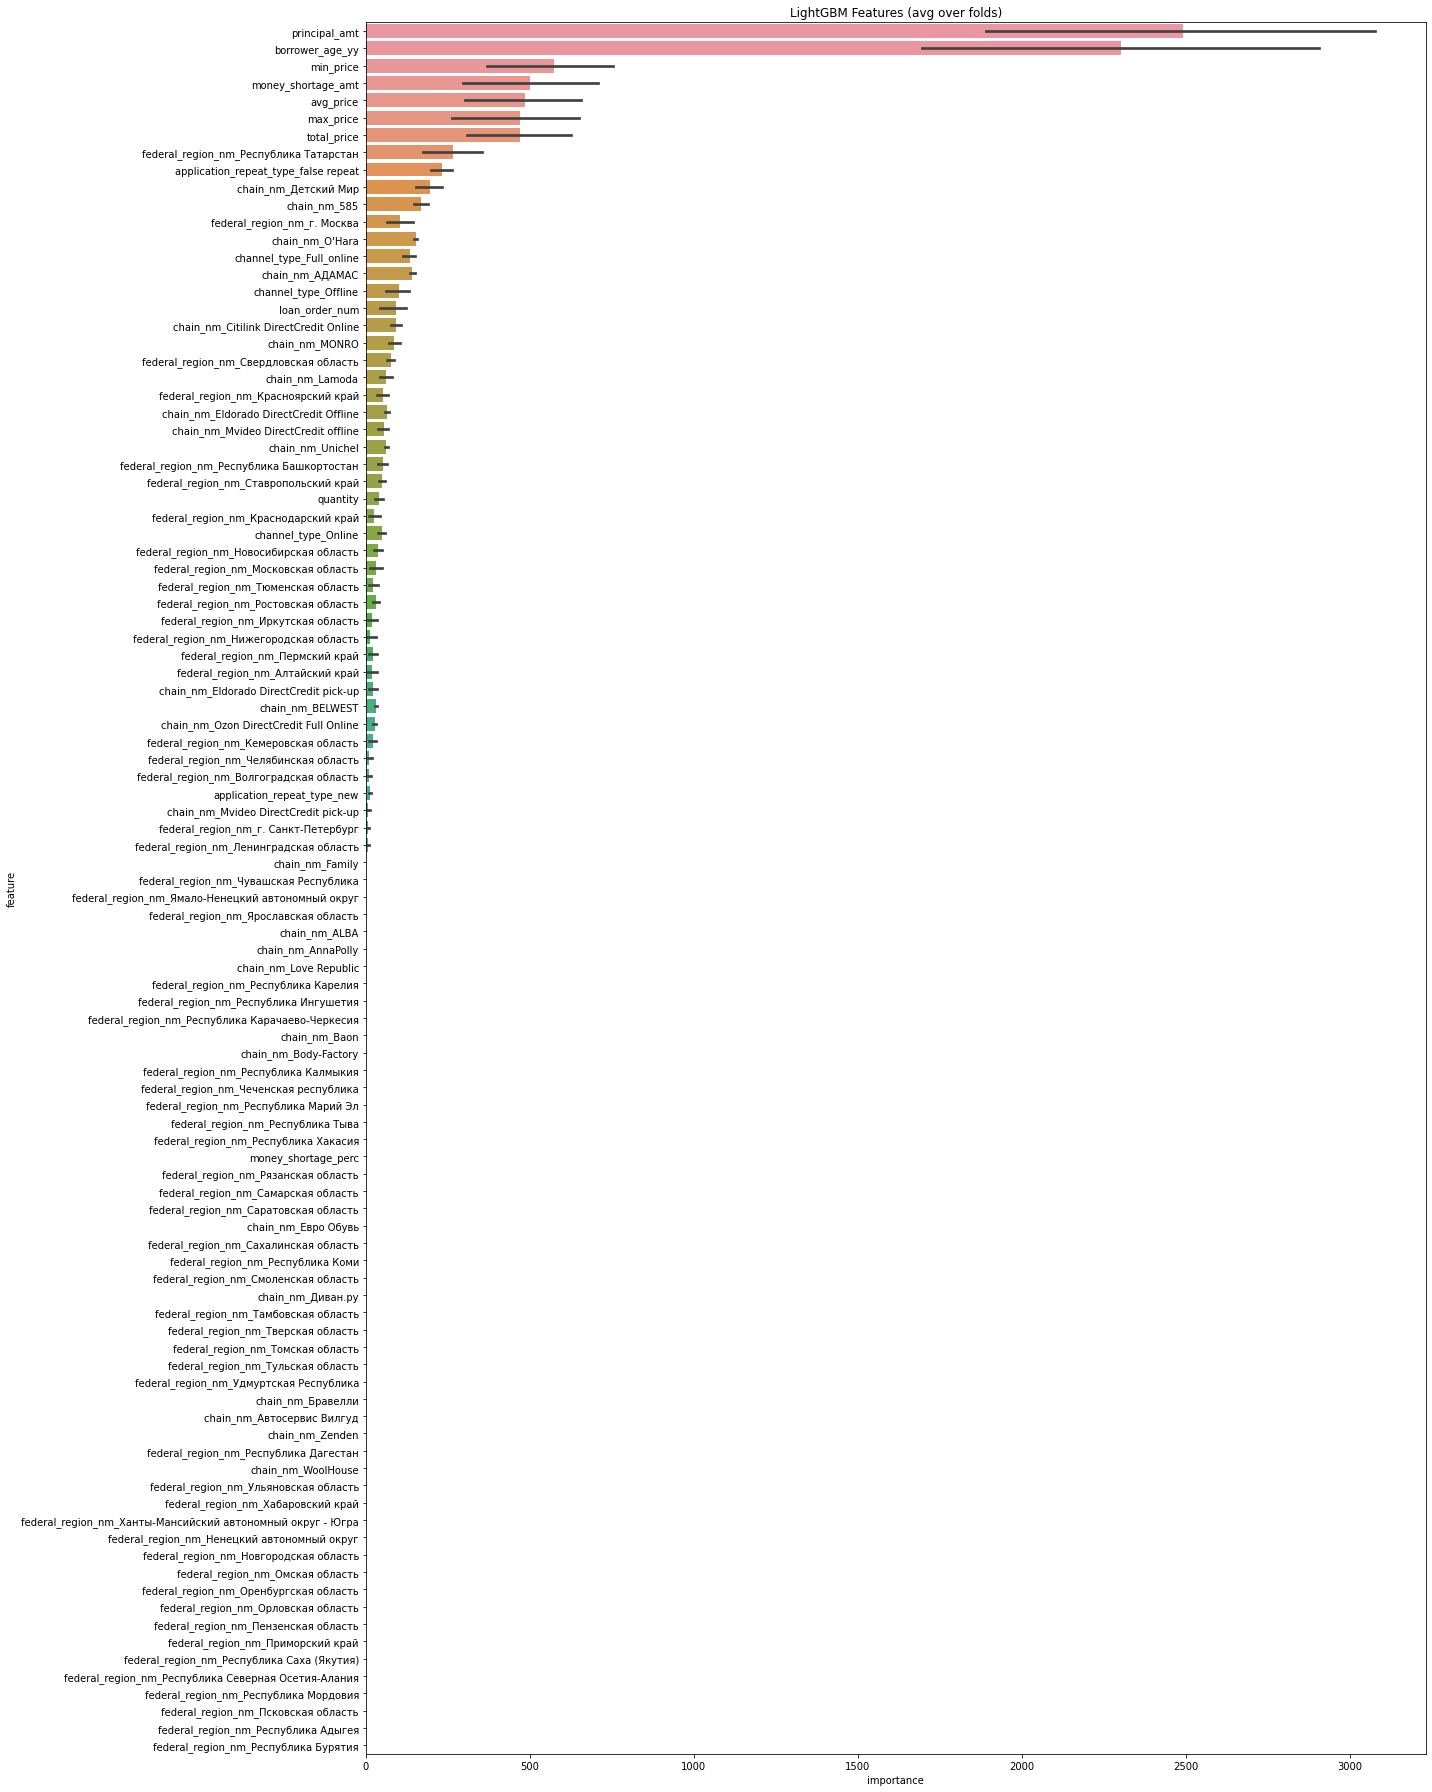

In [82]:
display_importances(feature_importance_df)

# Commented

In [32]:
'''
loan_application_id = []
name = []
price = []
quantity = []

with tqdm(total=ds_1.shape[0]) as pbar:
    for _, row in ds_1.iterrows():
        pbar.update(1)
        ds_json = pd.DataFrame.from_dict(row["cart_items"])
        for i in range(0,ds_json.shape[0]):
            loan_application_id.append(row["loan_application_id"])
            name.append(ds_json["name"][i])
            price.append(ds_json["price"][i])
            quantity.append(ds_json["quantity"][i])

        #print(ds_json.shape)
        #print(ds_json)
        #break
'''

100%|██████████| 1654637/1654637 [15:47<00:00, 1745.68it/s]


In [29]:
ds_1 = pd.read_csv("/home/amadeus/Desktop/kaggle/Yury/Mokka_test/input_data/cart_items.csv",sep=";")

In [30]:
ds_1['cart_items']=ds_1['cart_items'].apply(lambda x:eval(x))

In [32]:
ds_1['cart_items'][0]

[{'name': 'Смартфон Apple iPhone 8 Plus 64GB\xa0Space Gray (MQ8L2RU/A)',
  'price': '44990',
  'quantity': '1'},
 {'name': 'Чехол для iPhone Apple iPhone 8 Plus / 7 Plus Silicone Black (MQGW2ZM/A)',
  'price': '2990',
  'quantity': '1'}]

In [33]:
ds_1[ds_1["loan_application_id"] == 10565286]

,loan_application_id,cart_items


In [33]:
ds_1_amended = pd.DataFrame(list(zip(loan_application_id, name,price,quantity)),
               columns =['loan_application_id', 'name', 'price', 'quantity'])

In [15]:
sqldf(
    '''
SELECT 
    federal_region_nm
    ,SUM(target) AS event
    ,COUNT(target) AS total_events
    ,SUM(target)/COUNT(target) AS event_rate
    ,(COUNT(target) ) AS perc
    ,(SELECT COUNT(target) FROM DS_EDA) AS total
FROM 
    DS_EDA
GROUP BY
    federal_region_nm
ORDER BY
    total_events DESC        
''')

,federal_region_nm,event,total_events,event_rate,perc,total
0,г. Москва,808.0,13706,0.058952,13706,82673
1,Московская область,265.0,4927,0.053785,4927,82673
2,Кемеровская область,111.0,3449,0.032183,3449,82673
3,Краснодарский край,211.0,3339,0.063193,3339,82673
4,Новосибирская область,88.0,3172,0.027743,3172,82673
...,...,...,...,...,...,...
75,Ямало-Ненецкий автономный округ,7.0,38,0.184211,38,82673
76,Камчатский край,1.0,36,0.027778,36,82673
77,Еврейская автономная область,1.0,14,0.071429,14,82673
78,None,3.0,14,0.214286,14,82673


In [24]:
sqldf(
'''
SELECT
    target
    ,application_repeat_type
    ,COUNT(*) AS CNT
FROM
    ds_2
GROUP BY
    target
    ,application_repeat_type
'''
)

sqldf(
'''

SELECT
    client_id
    ,COUNT(client_id) client_count
    ,sum(target) tar
FROM
    AGGREGATED_DS
GROUP BY
    client_id
ORDER BY
    client_count
'''
)

sqldf(
'''
SELECT
    *
FROM
    AGGREGATED_DS
WHERE
    1 = 1
    AND client_id = 601729
'''
)

,client_id,client_count,sum(target)
0,22872,1,NaN
1,38866,1,NaN
2,69080,1,NaN
3,72911,1,0.0
4,78191,1,NaN
...,...,...,...
1091606,601729,18,NaN
1091607,2567924,18,NaN
1091608,279502,20,NaN
1091609,2327833,24,NaN


In [36]:
ds_1_amended.to_csv("/home/amadeus/Desktop/kaggle/Yury/Mokka_test/input_data/cart_items_amended.csv")

In [16]:
sqldf(
    '''
select 
    channel_type
    ,sum(target) as event
    ,count(target) as total_events
    ,sum(target)/count(target) as event_rate
    ,(count(target) ) as perc
    ,(select count(target) from DS_EDA) as total
from 
    DS_EDA
group by
    channel_type
order by
    total_events desc        
''')

,channel_type,event,total_events,event_rate,perc,total
0,Offline,2891.0,62492,0.046262,62492,82673
1,Online,967.0,17166,0.056332,17166,82673
2,Full_online,271.0,3015,0.089884,3015,82673


In [17]:
sqldf(
    '''
select 
    birth_dt
    ,sum(target) as event
    ,count(target) as total_events
    ,sum(target)/count(target) as event_rate
    ,(count(target) ) as perc
    ,(select count(target) from DS_EDA) as total
from 
    DS_EDA
group by
    birth_dt
order by
    total_events desc        
''')

,birth_dt,event,total_events,event_rate,perc,total
0,1987-11-03,0.0,20,0.000000,20,82673
1,1988-10-04,0.0,19,0.000000,19,82673
2,1987-01-09,1.0,19,0.052632,19,82673
3,1986-11-07,0.0,19,0.000000,19,82673
4,1990-04-17,2.0,18,0.111111,18,82673
...,...,...,...,...,...,...
18260,1941-07-04,0.0,1,0.000000,1,82673
18261,1884-07-19,0.0,1,0.000000,1,82673
18262,1198-06-21,0.0,1,0.000000,1,82673
18263,1070-03-11,0.0,1,0.000000,1,82673
